In [1]:
from final_utils import *

In [2]:
root_path = generate_root_path()

## Creating model

In [3]:
def calc_acc(labels, predicted):
    '''
    Calculating mean class error, e.g. predicted classes are 1vs0, 0vs0, 0vs0, 0vs0, then we have acc=0.25
    Inputs: 
        labels = target labels
        predicted = predicted binary probability distribution for the input
    Output:
        mean class error
    '''
    acc = np.sum(np.array(labels) == np.argmax(np.array(predicted), axis=1)) / len(labels)
    return np.round(acc * 100, 2)

In [4]:
# with tf.device('/GPU'): 
#creating feature extractors
model_gap = model_inceptionresnet_multigap()
model_cnn = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1", trainable=False)])

#creating dense and loading the weights
model = fc_model_softmax(input_num=5000)
weights_path = f'Genetic_Algorithm/best_res_all_res_996/best_custom_94.06.hdf5'
model.load_weights(weights_path)

### Loading PCA models 

In [5]:
# Use pca to reduce dimensionality. Load pca models

def pca_transform(vector, path):
    pca = pk.load(open(path,'rb'))
    return pca.transform(vector)

# pca_mg_path = 'models/PCA/PCA_MultiGap_8464_auto.pkl'
# pca_cnn_path = 'models/PCA/PCA_CNN_1280_auto.pkl'
# pca_connected_path ='models/PCA/test_PCA_augm_9744_auto.pkl'

pca_mg = None #pk.load(open(pca_mg_path,'rb'))
pca_cnn = None #pk.load(open(pca_cnn_path,'rb'))
pca_connected = None# pk.load(open(pca_connected_path,'rb'))

# Or use take to reduce dimensionality
def take_from_feats(data, idx):
    new_data = np.squeeze(data[:, idx])
    return new_data

indxs = np.load(f'Genetic_Algorithm/best_res_all_res_996/best_solution_custom_94.06.npy')

# Evaluating using benchmark extracted features

## Giving path of folder

In [6]:
def loading_bench_datas(bench_path=root_path + 'Data/AesthAI/benchmark_connected/', feats_MG='max_996',
                        feats_CNN='border_600x600', cnn='cnn_efficientnet_b7'):
       
    bench_bad = open(f'{bench_path}data_bad.json')
    bad_data = json.load(bench_bad)
    bench_bad = []
    bench_bad_path = []
    

    for data in bad_data:
            feat_path_1 = bench_path + f'features/multigap/{feats_MG}/' + data['feature']
            feat_path_2 = bench_path + f'features/{cnn}/{feats_CNN}/' + data['feature']
            connected = np.concatenate((np.squeeze(np.load(feat_path_1)), np.squeeze(np.load(feat_path_2))))
            bench_bad.append(connected)
            bench_bad_path.append(bench_path + 'images/' + data['label'] + '/' + data['name'])
          
    try: # COCO dataset has no data_good.json
        bench_good = open(f'{bench_path}data_good.json')
        good_data = json.load(bench_good)
        bench_good = []
        bench_good_path = []
        for data in good_data:
            feat_path_1 = bench_path + f'features/multigap/{feats_MG}/' + data['feature']
            feat_path_2 = bench_path + f'features/{cnn}/{feats_CNN}/' + data['feature']
            connected = np.concatenate((np.squeeze(np.load(feat_path_1)), np.squeeze(np.load(feat_path_2))))
            bench_good.append(connected)
            bench_good_path.append(bench_path + 'images/' + data['label'] + '/' + data['name'])
    except:
        pass
    
    try: # Again for Coco
        bench_path = bench_bad_path + bench_good_path
        bench = np.concatenate((bench_bad, bench_good))
    except:
        bench = np.array(bench_bad)
        bench_path = np.array(bench_bad_path)
        
    bench_labels = np.concatenate((np.zeros(len(bench_bad)), np.ones(len(bench_good))))
    
    return bench, bench_path, bench_labels

In [9]:
def loading_bench_datas_resnet(bench_path=root_path + 'Data/AesthAI/benchmark_connected/', feats_res='border_600x600'):
       
    bench_bad = open(f'{bench_path}data_bad.json')
    bad_data = json.load(bench_bad)
    bench_bad = []
    bench_bad_path = []
    for data in bad_data:
            feat_path_1 = bench_path + f'features/resnet/{feats_res}/' + data['feature']
            bench_bad.append(np.squeeze(np.load(feat_path_1)))
            bench_bad_path.append(bench_path + 'images/' + data['label'] + '/' + data['name'])
          
    try: # COCO dataset has no data_good.json
        bench_good = open(f'{bench_path}data_good.json')
        good_data = json.load(bench_good)
        bench_good = []
        bench_good_path = []
        for data in good_data:
            feat_path_1 = bench_path + f'features/resnet/{feats_res}/' + data['feature']
            bench_good.append(np.squeeze(np.load(feat_path_1)))
            bench_good_path.append(bench_path + 'images/' + data['label'] + '/' + data['name'])
            
    except:
        pass
    
    try: # Again for Coco
        bench_path = bench_bad_path + bench_good_path
        bench = np.concatenate((bench_bad, bench_good))
    except:
        bench = np.array(bench_bad)
        bench_path = np.array(bench_bad_path)
 

    bench_labels = np.concatenate((np.zeros(len(bench_bad)), np.ones(len(bench_good))))
    
    return bench, bench_path, bench_labels

## Loading bench datas 

In [7]:
bench_1, bench_1_path, bench_1_labels = loading_bench_datas(bench_path = root_path + 'Data/AesthAI/benchmark/', feats_MG = 'max_996',
                        feats_CNN = 'border_600x600', cnn = 'cnn_efficientnet_b7')
bench_2, bench_2_path, bench_2_labels = loading_bench_datas(bench_path = root_path + 'Data/AesthAI/benchmark2/', feats_MG = 'max_996',
                        feats_CNN = 'border_600x600', cnn = 'cnn_efficientnet_b7')
bench_connected, bench_connected_path, bench_connected_labels = loading_bench_datas(bench_path = root_path + 'Data/AesthAI/benchmark_connected/', feats_MG = 'max_996',
                        feats_CNN = 'border_600x600', cnn = 'cnn_efficientnet_b7')
coco, coco_path, coco_labels = loading_bench_datas(bench_path = root_path + 'Data/AesthAI/Coco/', feats_MG = 'max_996',
                        feats_CNN = 'border_600x600', cnn = 'cnn_efficientnet_b7')
sven_custom, sven_custom_path, sven_custom_labels = loading_bench_datas(bench_path = root_path + 'Data/AesthAI/Sven_custom_data/', feats_MG = 'max_996',
                        feats_CNN = 'border_600x600', cnn = 'cnn_efficientnet_b7')
alm, alm_path, alm_labels = loading_bench_datas(bench_path = root_path + 'Data/AesthAI/alm/splitted/alm_bench/', feats_MG = 'max_996',
                        feats_CNN = 'border_600x600', cnn = 'cnn_efficientnet_b7')

## Loading bench datas for resnet

In [10]:
bench_1, bench_1_path, bench_1_labels = loading_bench_datas_resnet(bench_path = root_path + 'Data/AesthAI/benchmark/', feats_res='border_600x600_5k_94_24')
bench_2, bench_2_path, bench_2_labels = loading_bench_datas_resnet(bench_path = root_path + 'Data/AesthAI/benchmark2/',feats_res='border_600x600_5k_94_24')
bench_connected, bench_connected_path, bench_connected_labels = loading_bench_datas_resnet(bench_path = root_path + 'Data/AesthAI/benchmark_connected/',
                                                                                   feats_res='border_600x600_5k_94_24')

## Take necessary indices 

In [8]:
# Loading the solution to take from benchmark1 vectors
bench_1 = take_from_feats(bench_1, indxs)

In [9]:
# Loading the solution to take from benchmark2 vectors
bench_2 = take_from_feats(bench_2, indxs)

In [10]:
# Loading the solution to take from benchmark connected vectors
bench_connected = take_from_feats(bench_connected, indxs)

In [11]:
# Loading the solution to take from coco vectors
coco = take_from_feats(coco, indxs)

In [12]:
# Loading the solution to take from Sven_custom vectors
sven_custom = take_from_feats(sven_custom, indxs)

In [13]:
# Loading the solution to take from alm vectors
alm = take_from_feats(alm, indxs)

### Benchmark 1

In [14]:
# Predict on benchmark 1 
predicted = model.predict(bench_1)

4/4 [==============================] - 1s 2ms/step


In [15]:
acc = calc_acc(bench_1_labels, predicted)
print(f'Accuarcy: {acc}')

Accuarcy: 86.49


In [16]:
# Precision, Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(bench_1_labels, pred)

Precision: 92.11 %
Recall: 74.47 %


### Benchmark 2 

In [17]:
# Predict on benchmark 2
predicted = model.predict(bench_2)

33/33 [==============================] - 0s 1ms/step


In [18]:
acc = calc_acc(bench_2_labels, predicted)
print(f'Accuarcy: {acc}')

Accuarcy: 94.87


In [19]:
# Precision, Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(bench_2_labels, pred)

Precision: 95.64 %
Recall: 94.38 %


### Benchmark  joint

In [20]:
# Predict on joint benchmark 
predicted = model.predict(bench_connected)

36/36 [==============================] - 0s 1ms/step


In [21]:
acc = calc_acc(bench_connected_labels, predicted)
print(f'Accuarcy: {acc}')

Accuarcy: 94.06


In [22]:
# Precision, Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(bench_connected_labels, pred)

Precision: 95.4 %
Recall: 92.77 %


### Alm Benchmark

In [24]:
# Predict on Alm data
predicted = model.predict(alm)

7/7 [==============================] - 0s 5ms/step


In [25]:
acc = calc_acc(alm_labels, predicted)
print(f'Coco Accuarcy: {acc}')

Coco Accuarcy: 96.5


In [26]:
# Precision, Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(alm_labels, pred)

Precision: 94.29 %
Recall: 99.0 %


### Sven Custom

In [27]:
# Predict on Sven data
predicted = model.predict(sven_custom)

7/7 [==============================] - 0s 5ms/step


In [28]:
acc = calc_acc(sven_custom_labels, predicted)
print(f'Accuarcy: {acc}')

Accuarcy: 93.5


In [29]:
# Precision, Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(sven_custom_labels, pred)

Precision: 93.07 %
Recall: 94.0 %


### Coco

In [30]:
# Predict on joint benchmark 
predicted = model.predict(coco)

32/32 [==============================] - 0s 5ms/step


In [31]:
acc = calc_acc(coco_labels, predicted)
print(f'Accuarcy: {acc}')

Accuarcy: 94.6


# Evaluation using benchmark images 

### Some necessary functions for predictions

In [33]:
def predict(x, y=None, model_gap=None, model=None, model_cnn=None, is_norm=False, 
            pca_mg=None, pca_cnn=None, pca_connected=None, take=False):
    '''
    Does prediction on given numpy image using
    model_gap and model
    '''
    try:
        feat_mg = model_gap.predict(x, verbose=0)
    except:
        x = x[None] #changed 02.08 for evaluator visualizing predictions
        feat_mg = model_gap.predict(x, verbose=0)
        
    if pca_mg:
        feat_mg = pca_mg.transform(feat_mg) 

    if model_cnn:
        feat_cnn = model_cnn.predict(y, verbose=0)
        if is_norm:
            feat_cnn = normalize_feat_vector(feat_cnn)
        if pca_cnn:
            feat_cnn = pca_cnn.transform(feat_cnn)
            
        feat = np.concatenate((np.squeeze(feat_mg), np.squeeze(feat_cnn)))
        if pca_connected:
            feat = pca_connected.transform(feat[None])
        if take:
            feat = np.take(feat, indxs)#take_from_vector(feat, indxs)
            
        feat = feat[None]
    else:
        feat = feat_mg
    pred_score = model.predict(feat, verbose=0)

    return pred_score
    

def predict_from_path(model_gap, model, paths, resize_func=None, size=None, for_all=False, save_results=None, 
                      save_to=None, model_cnn=None, is_norm=False, pca_mg = None, pca_cnn = None, pca_connected=None, take=False):
    #always requires list of paths
    predicted = []
    
    for i, path in enumerate(paths):
        img_mg = read_img(path=path, resize_func=resize_func, size=size, for_all=for_all)
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn, pca_connected, take)
        predicted.append(pred_score)
    
    predicted = np.array(predicted)
    predicted = np.squeeze(predicted)
    
    if save_results:
        np.save(save_to, np.argmax(predicted, axis=-1))
        
    return predicted

def plot_pred_orig(model_gap, model, imgs_bench, label=None, row_count=2, column_count=10, resize_func=None, size=None,
                   for_all=False, model_cnn=None, is_norm=False, pca_mg=None, pca_cnn=None, pca_connected=None, take=False):
    f, axarr = plt.subplots(row_count, column_count,  figsize=(20,5))

    for i, path in enumerate(imgs_bench):
        x = i // column_count
        y = i % column_count

        img_mg = read_img(path, resize_func=resize_func, size=size, for_all=for_all)
        
        img_cnn = None
        if model_cnn:
            img_cnn = read_img(path=path, resize_func=resize_add_border, size=(600, 600))
            
        pred_score = predict(img_mg, img_cnn, model_gap, model, model_cnn, is_norm, pca_mg, pca_cnn, pca_connected, take)

        im = cv2.imread(path)
        im = cv2.resize(im, (400, 400))
        
        if row_count == 1:
            axarr[i].imshow(im[..., ::-1]) 
            axarr[i].set_title(f'{str(np.argmax(pred_score, axis=-1)[0])}\n{str(np.round(np.max(pred_score, axis=-1),3)[0])}', fontsize=12)
        else:
            axarr[x, y].imshow(im[..., ::-1]) 
            axarr[x, y].set_title(f'{str(np.argmax(pred_score, axis=-1)[0])}\n{str(np.round(np.max(pred_score, axis=-1),3)[0])}', fontsize=12)

    if label:
        f.suptitle('DeepFL test on ' + label, fontsize=17)
    else: 
        f.suptitle('DeepFL Predictions', fontsize=17)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()


## Prediction on benchmark 1 

In [33]:
#resize_max (996, 996) means if images' height or width > 996 then resize with maximum 996 and another with aspect ratio
predicted = predict_from_path(model_gap, model, bench_1_path, resize_func=resize_max, 
                          size=(996, 996), for_all=True, model_cnn=model_cnn, 
                          is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn,
                          pca_connected=pca_connected, take=True)

2022-11-28 02:30:25.681900: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-28 02:30:26.228004: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-28 02:30:26.228348: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-28 02:30:26.228367: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-28 02:30:26.228906: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-28 02:30:26.229000: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [34]:
acc = calc_acc(bench_1_labels, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 85.59 %


In [35]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(bench_1_labels, pred)

Precision: 89.74 %
Recall: 74.47 %


## Prediction on benchmark 2

In [36]:
predicted = predict_from_path(model_gap, model, bench_2_path, resize_func=resize_max, 
                          size=(996, 996), for_all=True, model_cnn=model_cnn, 
                          is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn,
                          pca_connected=pca_connected, take=True)

In [37]:
acc = calc_acc(bench_2_labels, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 94.78 %


In [38]:
pred = np.argmax(predicted, axis=1)
calc_metrics(bench_2_labels, pred)

Precision: 94.78 %
Recall: 95.13 %


## Prediction on joint benchmark 


In [40]:
predicted = predict_from_path(model_gap, model, bench_connected_path, resize_func=resize_max, 
                          size=(996, 996), for_all=True, model_cnn=model_cnn, 
                          is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn,
                          pca_connected=pca_connected, take=True)

In [41]:
acc = calc_acc(bench_connected_labels, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 93.89 %


In [42]:
pred_images = np.argmax(predicted, axis=1)
calc_metrics(bench_connected_labels, pred_images)

Precision: 94.43 %
Recall: 93.46 %


## Prediction on alm benchmark

In [45]:
predicted = predict_from_path(model_gap, model, alm_path, resize_func=resize_max, 
                      size=(996, 996), for_all=True, model_cnn=model_cnn, 
                      is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn, 
                      pca_connected=pca_connected, take=True)

In [46]:
acc = calc_acc(alm_labels, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 97.5 %


In [47]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(alm_labels, pred)

Precision: 97.98 %
Recall: 97.0 %


## Prediction on Sven custom data

In [48]:
predicted = predict_from_path(model_gap, model, sven_custom_path, resize_func=resize_max, 
                          size=(996, 996), for_all=True, model_cnn=model_cnn,
                          is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn,
                          pca_connected=pca_connected, take=True)

In [49]:
acc = calc_acc(sven_custom_labels, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 97.0 %


In [50]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(sven_custom_labels, pred)

Precision: 98.96 %
Recall: 95.0 %


# Prediction on Coco

In [43]:
predicted = predict_from_path(model_gap, model, coco_path, resize_func=resize_max, 
                          size=(996, 996), for_all=True, model_cnn=model_cnn, 
                          is_norm=False, pca_mg = pca_mg, 
                          pca_cnn = pca_cnn, pca_connected=pca_connected,  take=True)

In [44]:
acc = calc_acc(coco_labels, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 99.2 %


## Get paths for visualization

In [65]:
def get_path_img(bench_path):
    bad_img_path = []
    good_img_path = []
    for i in bench_path:
        if 'good' in i:
            good_img_path.append(i)
        else:
            bad_img_path.append(i)
    
    return good_img_path, bad_img_path

In [69]:
bench1_good, bench1_bad = get_path_img(bench_1_path)
bench2_good, bench2_bad = get_path_img(bench_2_path)

## Visualizing predictions on benchmark

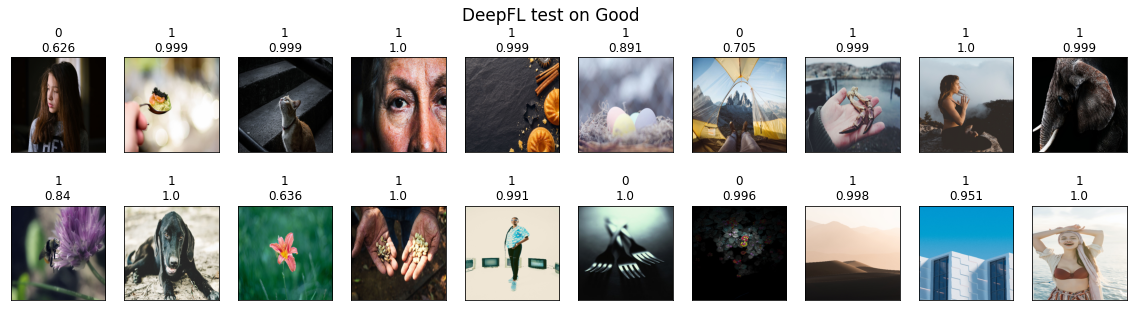

In [70]:
data_size = 20

plot_pred_orig(model_gap, model, bench1_good[0:20], resize_func=resize_max, 
               label='Good', size=(996, 996), for_all=True, model_cnn=model_cnn, 
               is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn, pca_connected=pca_connected, take=True)

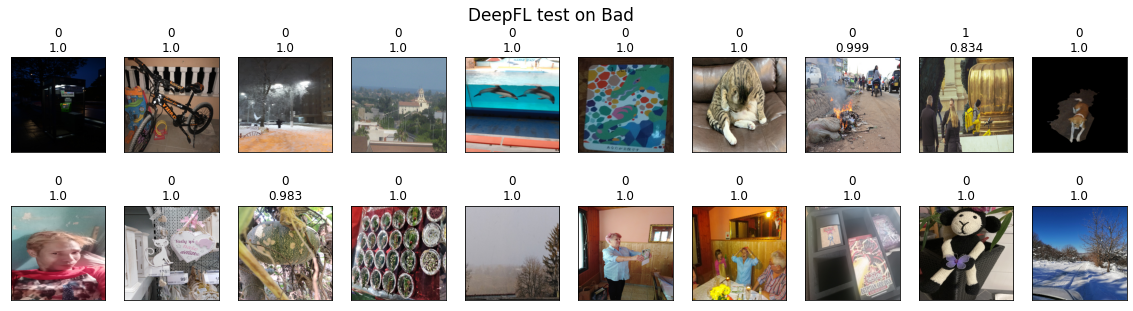

In [71]:
data_size = 20

plot_pred_orig(model_gap, model, bench1_bad[20:40], resize_func=resize_max, 
              label='Bad', size=(996, 996), for_all=True, model_cnn=model_cnn,
               is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn, pca_connected=pca_connected, take=True)

## Visualizing predictions on benchmark2

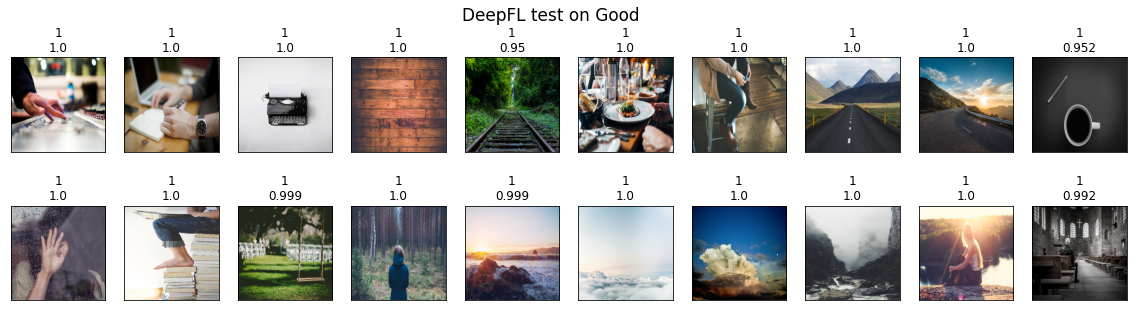

In [72]:
data_size = 20

plot_pred_orig(model_gap, model, bench2_good[:data_size], resize_func=resize_max, 
               label='Good', size=(996, 996), for_all=True, model_cnn=model_cnn, 
               is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn, pca_connected=pca_connected, take=True)

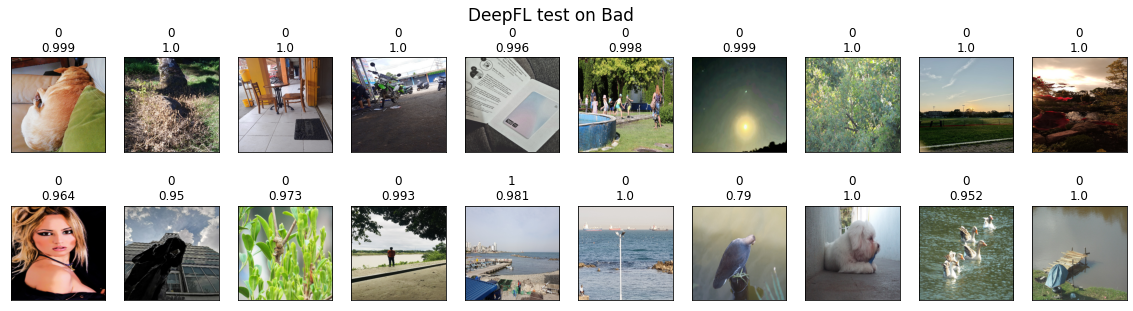

In [73]:
data_size = 20

plot_pred_orig(model_gap, model, bench2_bad[:data_size], resize_func=resize_max, 
               label='Bad', size=(996, 996), for_all=True, model_cnn=model_cnn, 
               is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn, pca_connected=pca_connected, take=True)

## Visualizing predictions on Coco


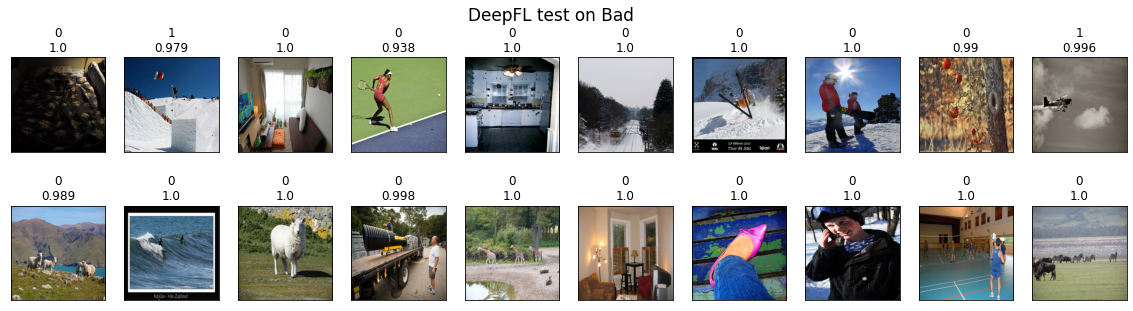

In [74]:
data_size = 20
plot_pred_orig(model_gap, model, coco_path[80:100], resize_func=resize_max, 
               label='Bad', size=(996, 996), for_all=True, model_cnn=model_cnn, 
               is_norm=False, pca_mg = pca_mg, pca_cnn = pca_cnn, pca_connected=pca_connected, take=True)